### Clustering single cell data using K-means, spectral, Louvain

Playing around with various clustering algorithms and how they work

In [6]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import sklearn
import sklearn.cluster
import sklearn.manifold

import scprep
import os
import tasklogger
import phate
import umap

import graphtools as gt
import phenograph
import louvain
import magic

<ipython-input-6-1c23c49fd636>:18: DeprecationWarning: This package has been superseded by the `leidenalg` package and will no longer be maintained. Please upgrade to the `leidenalg` package.
  import louvain


In [7]:
datapath = '/Users/anuraglimdi/Desktop/Single_cell_workshop/Datasets/'

In [9]:
data = pd.read_pickle(datapath+'embryoid_body_data.pickle.gz')
metadata = pd.read_pickle(datapath+'embryoid_body_metadata.pickle.gz')

### Denoising datasets:

Using the MAGIC tool which imputes missing values by finding similar cells (using a diffusion map approach)

In [10]:
marker_genes = scprep.select.get_gene_set(data, exact_word=[
    'ARID3A', 'ASCL2',  'CD34', 'CDX2', 'CER1', 'DLX1',
    'DMRT3', 'EN2', 'EOMES', 'FOXA2', 'FOXD3-AS1', 'GATA3-AS1',
    'GATA4', 'GATA5', 'GATA6-AS1', 'GBX2', 'GLI3', 'HOXA2',
    'HOXB1', 'HOXB4', 'HOXD13', 'HOXD9', 'ISL1', 'KLF5',
    'KLF7', 'LEF1', 'LHX2', 'LHX5', 'LMX1A', 'MAP2',
    'MIXL1', 'MYCBP', 'NANOG', 'NES', 'NKX2-1', 'NKX2-5',
    'NKX2-8', 'NPAS1', 'NR2F1-AS1', 'OLIG1', 'OLIG3', 'ONECUT1',
    'ONECUT2', 'OTX2', 'PAX3', 'PAX6', 'PDGFRA', 'PECAM1',
    'POU5F1', 'SATB1', 'SIX2', 'SIX3-AS1', 'SIX6', 'SOX13',
    'SOX10', 'SOX15', 'SOX17', 'SOX9', 'TTLL10', 'TAL1',
    'TBX15', 'TBX18', 'TBX5', 'TNNT2', 'WT1', 'ZBTB16',
    'ZIC2', 'ZIC5', 'ACTB', 'HAND1'])
marker_genes

array(['ACTB (ENSG00000075624)', 'ARID3A (ENSG00000116017)',
       'ASCL2 (ENSG00000183734)', 'CD34 (ENSG00000174059)',
       'CDX2 (ENSG00000165556)', 'CER1 (ENSG00000147869)',
       'DLX1 (ENSG00000144355)', 'DMRT3 (ENSG00000064218)',
       'EOMES (ENSG00000163508)', 'FOXA2 (ENSG00000125798)',
       'FOXD3-AS1 (ENSG00000230798)', 'GATA3-AS1 (ENSG00000197308)',
       'GATA4 (ENSG00000136574)', 'GATA5 (ENSG00000130700)',
       'GATA6-AS1 (ENSG00000266010)', 'GBX2 (ENSG00000168505)',
       'GLI3 (ENSG00000106571)', 'HAND1 (ENSG00000113196)',
       'HOXA2 (ENSG00000105996)', 'HOXB1 (ENSG00000120094)',
       'HOXB4 (ENSG00000182742)', 'HOXD9 (ENSG00000128709)',
       'ISL1 (ENSG00000016082)', 'KLF5 (ENSG00000102554)',
       'KLF7 (ENSG00000118263)', 'LEF1 (ENSG00000138795)',
       'LHX2 (ENSG00000106689)', 'LHX5 (ENSG00000089116)',
       'LMX1A (ENSG00000162761)', 'MAP2 (ENSG00000078018)',
       'MIXL1 (ENSG00000185155)', 'MYCBP (ENSG00000214114)',
       'NANOG (ENSG000001

In [11]:
data_magic = magic.MAGIC().fit_transform(data, genes=marker_genes)

Calculating MAGIC...
  Running MAGIC on 9717 cells and 14144 genes.
  Calculating graph and diffusion operator...
    Calculating PCA...
    Calculated PCA in 7.74 seconds.
    Calculating KNN search...
    Calculated KNN search in 6.36 seconds.
    Calculating affinities...
    Calculated affinities in 6.39 seconds.
  Calculated graph and diffusion operator in 21.00 seconds.
  Calculating imputation...
  Calculated imputation in 0.01 seconds.
Calculated MAGIC in 21.46 seconds.


In [29]:
data_umap = phate.PHATE().fit_transform(data)
data_umap = pd.DataFrame(data_umap, index=data.index)

Calculating PHATE...
  Running PHATE on 9717 observations and 14144 variables.
  Calculating graph and diffusion operator...
    Calculating PCA...
    Calculated PCA in 7.44 seconds.
    Calculating KNN search...
    Calculated KNN search in 6.46 seconds.
    Calculating affinities...
    Calculated affinities in 0.38 seconds.
  Calculated graph and diffusion operator in 14.68 seconds.
  Calculating landmark operator...
    Calculating SVD...
    Calculated SVD in 0.56 seconds.
    Calculating KMeans...
    Calculated KMeans in 7.83 seconds.
  Calculated landmark operator in 8.79 seconds.
  Calculating optimal t...
    Automatically selected t = 20
  Calculated optimal t in 2.71 seconds.
  Calculating diffusion potential...
  Calculated diffusion potential in 0.77 seconds.
  Calculating metric MDS...
  Calculated metric MDS in 2.86 seconds.
Calculated PHATE in 29.85 seconds.


<AxesSubplot:xlabel='PHATE1', ylabel='PHATE2'>

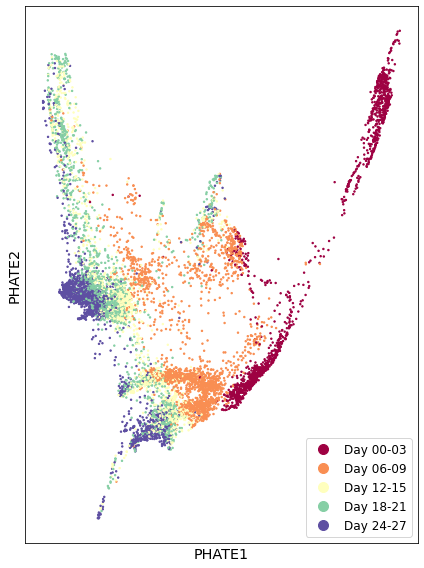

In [30]:
scprep.plot.scatter2d(data_umap, c=metadata['sample_labels'], figsize=(6,8), cmap="Spectral",
                      ticks=False, label_prefix="PHATE")

In [16]:
data_pca = scprep.reduce.pca(data, n_components=50, method='dense')

In [31]:
with tasklogger.log_task("KMeans"):
    kmeans_clusters = sklearn.cluster.KMeans(n_clusters=20).fit_predict(data_pca)

Calculating KMeans...
Calculated KMeans in 1.53 seconds.


In [32]:
G = gt.Graph(data_pca)
G_igraph = G.to_igraph()

In [33]:
with tasklogger.log_task("Louvain"):
    partition = louvain.find_partition(G_igraph, louvain.RBConfigurationVertexPartition, 
                                       weights="weight", resolution_parameter=1)
    louvain_clusters = np.array(partition.membership)

Calculating Louvain...
Calculated Louvain in 0.71 seconds.


In [34]:
with tasklogger.log_task("Spectral clustering"):
    spec_op = sklearn.cluster.SpectralClustering(n_clusters=20, affinity='precomputed')
    spectral_clusters = spec_op.fit_predict(G.K)

Calculating Spectral clustering...
Calculated Spectral clustering in 12.72 seconds.


In [35]:
clusterings = {
               'Louvain':louvain_clusters, 
               'KMeans':kmeans_clusters, 
               'Spectral':spectral_clusters}

for alg in clusterings:
    cl_nu = scprep.utils.sort_clusters_by_values(clusterings[alg], -data_umap.iloc[:,0])
    clusterings[alg] = cl_nu

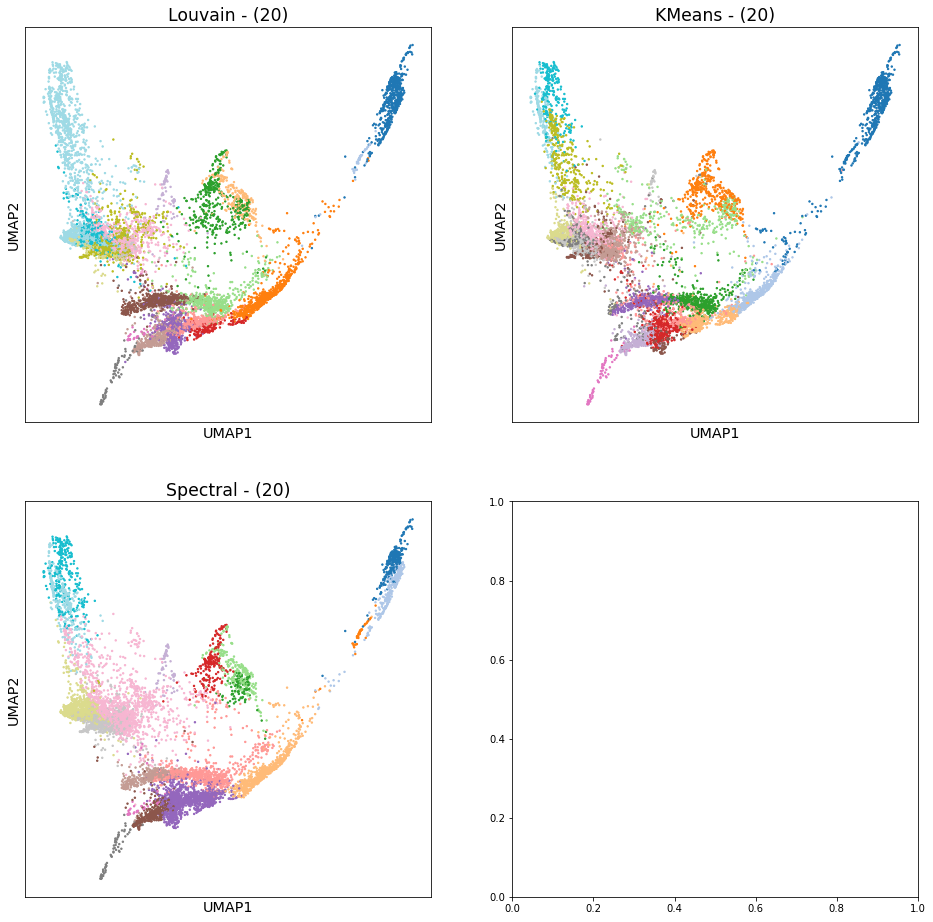

In [36]:
fig, axes = plt.subplots(2,2, figsize=(16,16))

for ax, algorithm in zip(axes.flatten(), clusterings):
    scprep.plot.scatter2d(data_umap, c=clusterings[algorithm], cmap=plt.cm.tab20,
                          title='{} - ({})'.format(algorithm, len(np.unique(clusterings[alg]))), 
                          ticks=False, label_prefix="UMAP", legend=False, discrete=True,
                          ax=ax)

In [37]:
all_clusterings = []
all_algorithms = list(clusterings.keys())
for algo in all_algorithms:
    all_clusterings.append(clusterings[algo])    
all_clusterings = np.vstack(all_clusterings)

In [39]:
from scipy.spatial.distance import pdist, squareform
cluster_similarities = squareform(pdist(all_clusterings, metric=sklearn.metrics.adjusted_rand_score))
# squareform assumes diagonals will be 0, but they're actually 1 because this is a similarity metric
# so we need to add 1's on the diagonal with np.eye()
cluster_similarities = cluster_similarities + np.eye(3)

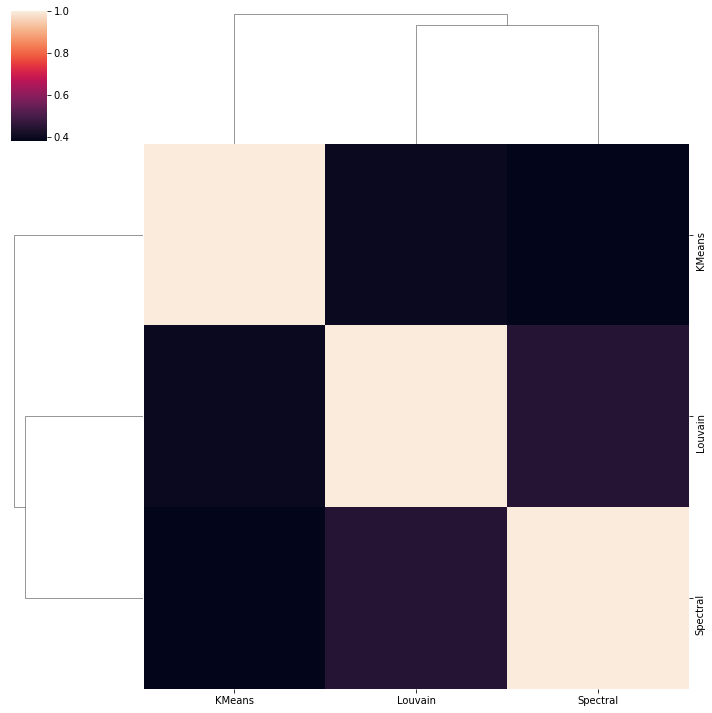

In [40]:
sns.clustermap(cluster_similarities, xticklabels=all_algorithms, yticklabels=all_algorithms)

<AxesSubplot:title={'center':'POU5F1'}, ylabel='POU5F1 (ENSG00000204531)'>

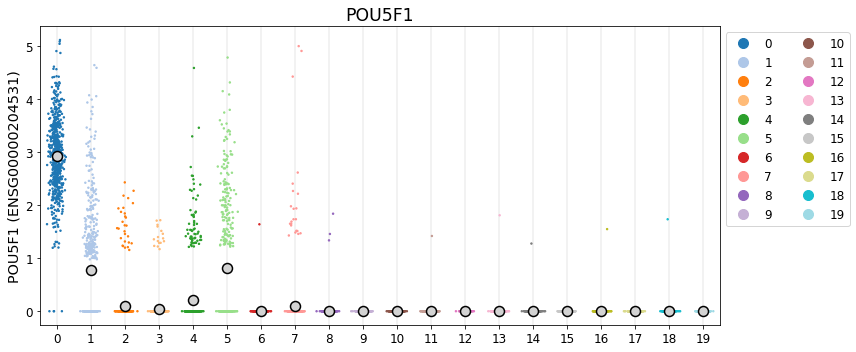

In [45]:
clusters = clusterings['KMeans']
curr_gene = 'POU5F1'
curr_expression = scprep.select.select_cols(data, exact_word=curr_gene)
scprep.plot.jitter(clusters, curr_expression, c=clusters, figsize=(12, 5),
                   legend_anchor=(1,1), title=curr_gene)

<AxesSubplot:title={'center':'POU5F1'}, ylabel='POU5F1 (ENSG00000204531)'>

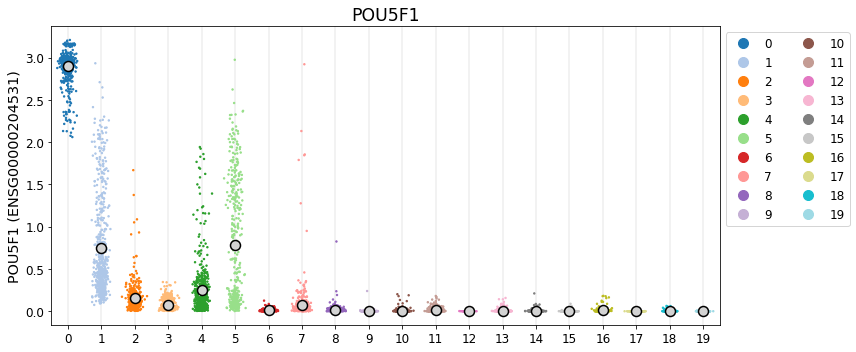

In [47]:
curr_gene = 'POU5F1'
curr_expression = scprep.select.select_cols(data_magic, exact_word=curr_gene)
scprep.plot.jitter(clusters, curr_expression, c=clusters, figsize=(12, 5),
                   legend_anchor=(1,1), title=curr_gene)